In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns
from sklearn.utils import resample

In [2]:
df_data = pd.read_csv('../Data/data_2/clean_review_60k.csv')
df_data

,text,label
0,bathroom desperately need cleaning recently re...,negative
1,believe PERSON property hotel disgust ORG ORG ...,negative
2,steer well clear recepionist seem problem fema...,negative
3,bad service ever front desk girl extremely rud...,negative
4,would stay free stay metropolitan partner TIME...,negative
...,...,...
59995,nice every aspect wife stay DATE DATE DATE ret...,positive
59996,comfortable convenient leisure TIME TIME DATE ...,positive
59997,great hotel good location great time stay ORG ...,positive
59998,would stay return home DATE GPE issue CARDINAL...,positive


In [3]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.5, smooth_idf=True)
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

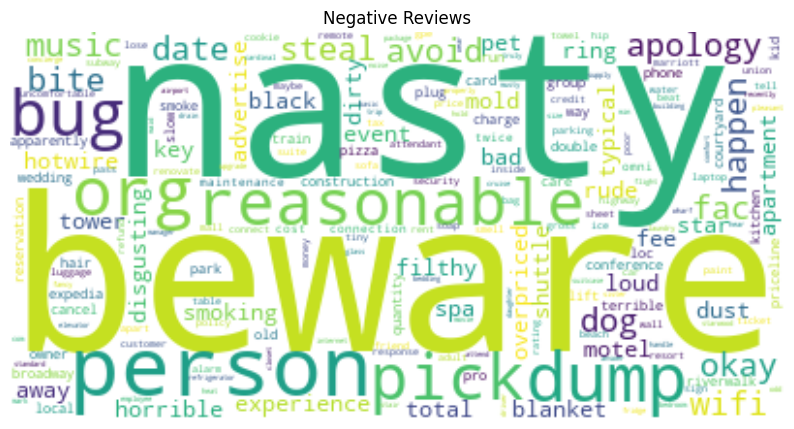

In [4]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


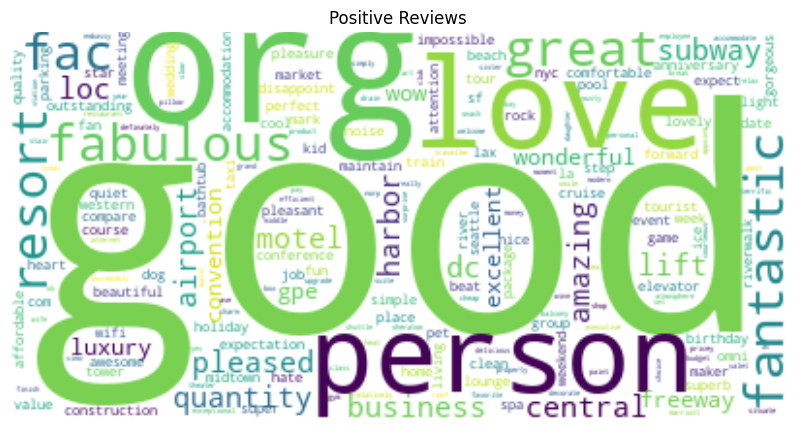

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


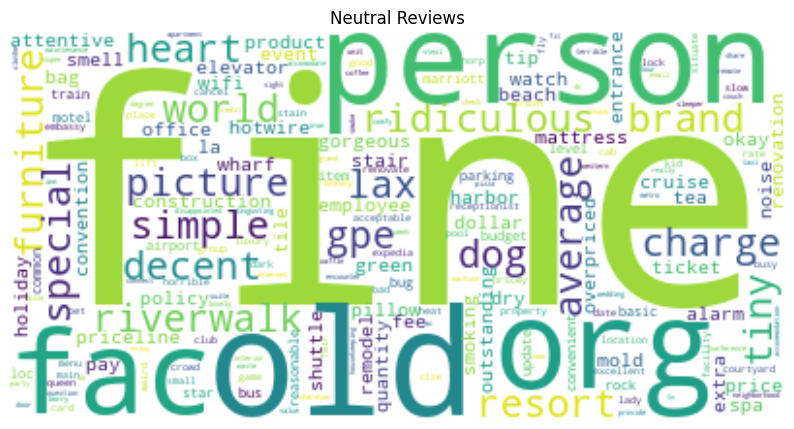

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [7]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [8]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,text,label
0,bathroom desperately need cleaning recently re...,2
1,believe PERSON property hotel disgust ORG ORG ...,2
2,steer well clear recepionist seem problem fema...,2
3,bad service ever front desk girl extremely rud...,2
4,would stay free stay metropolitan partner TIME...,2
...,...,...
59995,nice every aspect wife stay DATE DATE DATE ret...,0
59996,comfortable convenient leisure TIME TIME DATE ...,0
59997,great hotel good location great time stay ORG ...,0
59998,would stay return home DATE GPE issue CARDINAL...,0


In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((48000,), (12000,), (48000,), (12000,))

In [10]:
EMBEDDING_DIM = 50
MAXLEN = 50
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 20000
NUM_LABELS = 3

In [11]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [12]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [14]:
history = model.fit(x_train_pad, y_train, epochs=5, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/5
1500/1500 [==============================] - 119s 70ms/step - loss: 0.6645 - accuracy: 0.7131 - val_loss: 0.5916 - val_accuracy: 0.7540
Epoch 2/5
1500/1500 [==============================] - 100s 67ms/step - loss: 0.5265 - accuracy: 0.7838 - val_loss: 0.5788 - val_accuracy: 0.7505
Epoch 3/5
1500/1500 [==============================] - 77s 51ms/step - loss: 0.4670 - accuracy: 0.8114 - val_loss: 0.6050 - val_accuracy: 0.7397
Epoch 4/5
1500/1500 [==============================] - 81s 54ms/step - loss: 0.4104 - accuracy: 0.8388 - val_loss: 0.6611 - val_accuracy: 0.7222
Epoch 5/5
1500/1500 [==============================] - 81s 54ms/step - loss: 0.3451 - accuracy: 0.8677 - val_loss: 0.7243 - val_accuracy: 0.7221


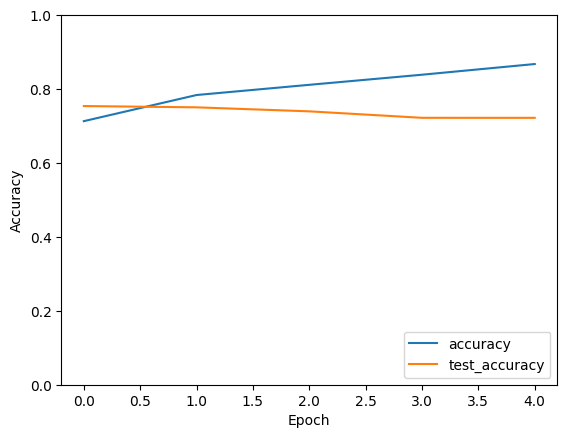

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [16]:
predictions = model.predict(x_test_pad)
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test, predictions)

375/375 [==============================] - 8s 14ms/step


In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4023
           1       0.62      0.62      0.62      4014
           2       0.76      0.75      0.76      3963

    accuracy                           0.72     12000
   macro avg       0.72      0.72      0.72     12000
weighted avg       0.72      0.72      0.72     12000



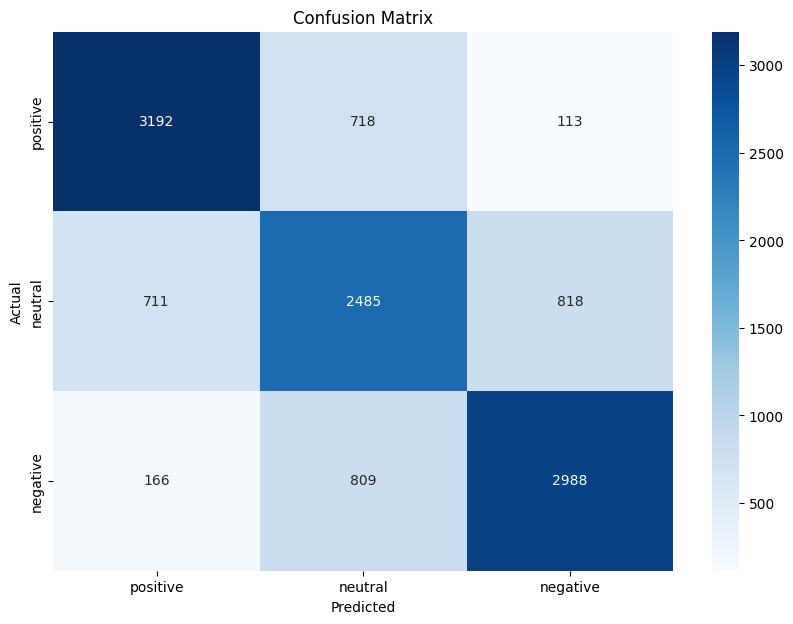

In [18]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()